# Pescanova Micro Notebook
* The **input** is a 6-pack image of agars with colonies.
* The desired **output** is a table with a prediction of how many vibrios/staphylos are in each row.

In [1]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

### Step 1: Picture to pred_on_all_agars
* First thing is identify position of agars and crop them:

In [3]:
# Read image
img = cv2.imread('tests/test_micro_plate_1.png')

In [4]:
# Import models: agar detection and colony detection
modelAgarsWells = YOLO('models/sample_model/model_agars_wells.pt')
modelColonies = YOLO('models/sample_model/model_all_augment.pt')

In [5]:
resultsAgars = modelAgarsWells(img)[0]
allBoxes = resultsAgars.boxes.xyxy.numpy().astype(int)

# These are the coordinates of the top-left corner of each agar
allBoxes[:, 0:2]


0: 384x640 6 agars, 73.6ms
Speed: 14.2ms preprocess, 73.6ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)


array([[ 681,  382],
       [1733, 1327],
       [ 720, 1350],
       [1705,  351],
       [2759, 1284],
       [2708,  316]])

In [6]:
def get_positions(circles, num_rows, num_cols):
    import numpy as np
    from sklearn.cluster import KMeans

    # Location algorithm for desired pocillo    
    x_kmeans = KMeans(n_clusters=num_cols, n_init=num_cols-1).fit(circles[:,0].reshape(-1, 1))
    x_labels, x_centers = x_kmeans.labels_, x_kmeans.cluster_centers_.squeeze()
    
    x_new_labels = np.zeros_like(x_labels)
    for i in range(len(x_centers)):
        x_new_labels[x_labels == i] = np.where(np.argsort(x_centers) == i)[0][0] 

    y_kmeans = KMeans(n_clusters=num_rows, n_init=num_rows-1).fit(circles[:,1].reshape(-1, 1))
    y_labels, y_centers = y_kmeans.labels_, y_kmeans.cluster_centers_.squeeze()
    
    y_new_labels = np.zeros_like(y_labels)
    for i in range(len(y_centers)):
        y_new_labels[y_labels == i] = np.where(np.argsort(y_centers) == i)[0][0]
        
    # Output is a dataframe where each row corresponds to a different circle.
    # We give coordinates of center, value of radius, row number and column number (in the grid)
    
    return np.column_stack((circles, y_new_labels+1,  x_new_labels+1))

In [7]:
agarsPositions = get_positions(allBoxes[:, 0:2], 2, 3)

# Sort the array first by the last column (index 3), then by the one before column (index 2)
sorted_indices = np.lexsort((agarsPositions[:, 3], agarsPositions[:, 2]))
# Here sorting is top-down, and left-right, so like:
# 1 2 3
# 4 5 6 
allBoxesSorted = allBoxes[sorted_indices]

* We next define *pred_on_all_agars*, a list of dictionaries containing colonies of each agar.

In [8]:
def get_path_dict(results):
    names = results[0].names
    number_colonies = np.zeros((len(names)), dtype = int)
    for i in range(0, len(results[0])):
        box = results[0].boxes[i]
        class_id = int(box.cls[0].item())
        number_colonies[class_id] = number_colonies[class_id] + 1

    counting = {}
    for i in range(0, len(names)):
        bacteria_name = names.get(i)
        counting[bacteria_name] = int(number_colonies[i])

    return counting


0: 640x640 6 valginos, 1 vharveyi, 80.3ms
Speed: 4.7ms preprocess, 80.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


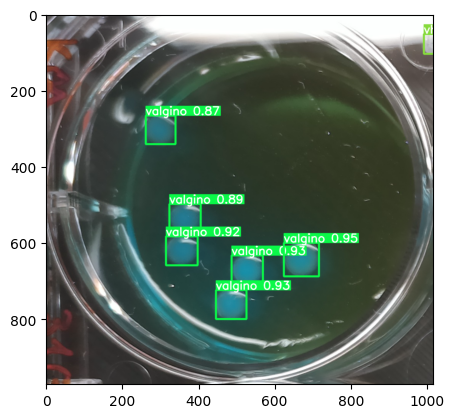


0: 640x640 1 pddamselae, 15 valginos, 2 vangils, 105.7ms
Speed: 7.0ms preprocess, 105.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


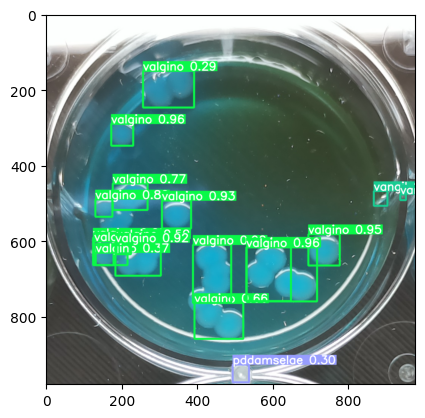


0: 640x640 23 valginos, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


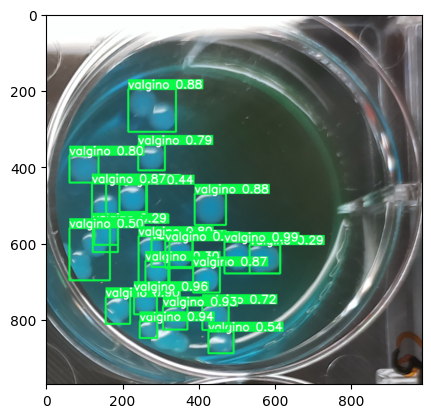


0: 640x640 4 pddamselaes, 12 valginos, 2 vangils, 1 vharveyi, 118.2ms
Speed: 4.8ms preprocess, 118.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


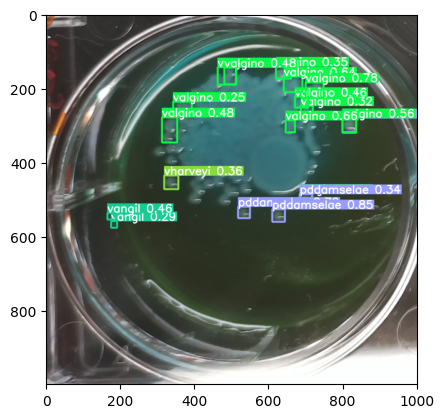


0: 608x640 1 assalmonicida, 2 sinniaes, 1 valgino, 4 vangils, 2 vharveyis, 90.3ms
Speed: 2.4ms preprocess, 90.3ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


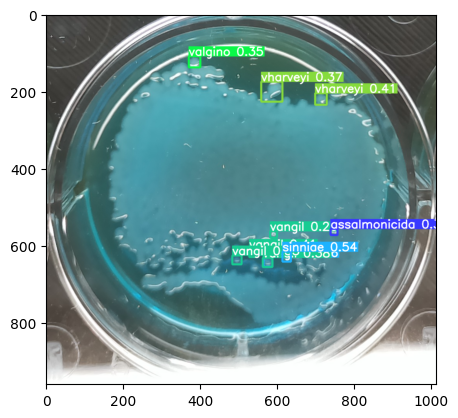


0: 640x640 1 valgino, 1 vangil, 99.3ms
Speed: 4.3ms preprocess, 99.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


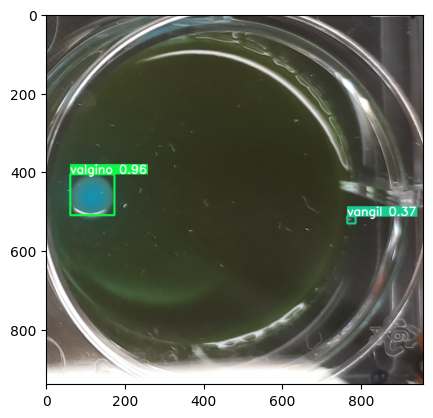

In [9]:
pred_on_all_agars = []

for box in allBoxesSorted:
    agarCrop = img[box[1]:box[3], box[0]:box[2]]

    # agarCrop = img.crop((box[0], box[1], box[2], box[3])) #for PIL images

    # Colonies prediction on agarCrop
    results = modelColonies(agarCrop)
    # Get count of each pathogen type
    path_dict = get_path_dict(results)
    # Plot results
    plt.imshow(results[0].plot())
    plt.show()

    # Append global list
    pred_on_all_agars.append(path_dict)

### Step 2: From pred_on_all_agars to pred_on_rows

In [11]:
# Prediction on rows only sees two pathogen classes: vibrio, staphylo (& none)
# Split pred_on_all_agars on two lists (one for each row)

upperRow, lowerRow = pred_on_all_agars[0:3],  pred_on_all_agars[3:6]

In [12]:
# To get a prediction on a row, we just look at the first agar (**this will need to be changed**)
# The result of arow-prediction is a count of vibrios, and a count of staphylos (at the moment there are not staphylo labels, so I'm just taking inniae, **this will also need to be changed**)

def get_row_pred(Row):
    row_pred = {'vibrios': Row[0]['valgino'] + Row[0]['vangil'] + Row[0]['vharveyi'],
     'staphylos': Row[0]['sinniae']}
    
    return row_pred

In [13]:
pred_on_rows = {'upperRow': get_row_pred(upperRow),'lowerRow': get_row_pred(lowerRow)}
pred_on_rows

{'upperRow': {'vibrios': 7, 'staphylos': 0},
 'lowerRow': {'vibrios': 15, 'staphylos': 0}}

### Step 3: From pred_on_rows to DB

In [21]:
sample_db_entry = {'plate_id': ['PESCXXXX'],
                   'date': ['00/00/00'],
                   'time': ['00:00:00'],
                   'upperRowVibrios': [pred_on_rows['upperRow']['vibrios']],
                   'upperRowStaphylos': [pred_on_rows['upperRow']['staphylos']],
                   'lowerRowVibrios': [pred_on_rows['lowerRow']['vibrios']],
                   'lowerRowStaphylos': [pred_on_rows['lowerRow']['staphylos']]}

In [22]:
pd.DataFrame(sample_db_entry)

,plate_id,date,time,upperRowVibrios,upperRowStaphylos,lowerRowVibrios,lowerRowStaphylos
0,PESCXXXX,00/00/00,00:00:00,7,0,15,0


#### Remark
* It's important to note that the predictions are made on **cropped images**, so the counts of vibrio/staphylo obtained may not match the ones on this image!


0: 384x640 28 valginos, 1 vangil, 2 vharveyis, 70.3ms
Speed: 6.9ms preprocess, 70.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


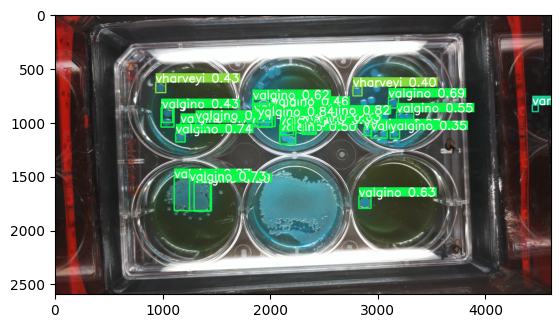

In [81]:
plt.imshow(modelColonies(img)[0].plot())

# Post processing filters

In [1]:
def post_processing_filter(path_counting, agar_type):

    # Define pathogens that have **no growth** in each of the media
    bloodNoGrowth, tcbsNoGrowth = {'tmaritimum'}, {'assalmonicida', 'pddamselae', 'pdpiscicida', 'tmaritimum'}

    # Replace with 0's all entries that contradict the no-growth theoretical data
    if agar_type == 'BA':
        for path in bloodNoGrowth:
            path_counting[path] = 0

    if agar_type == 'TCBS':
        for path in tcbsNoGrowth:
            path_counting[path] = 0
    
    return path_counting    

In [2]:
my_test_path_counting = {'assalmonicida': 0,
 'pddamselae': 1,
 'pdpiscicida': 0,
 'sinniae': 0,
 'tmaritimum': 0,
 'valgino': 15,
 'vangil': 2,
 'vharveyi': 0}

In [3]:
post_processing_filter(my_test_path_counting, 'TCBS')

{'assalmonicida': 0,
 'pddamselae': 0,
 'pdpiscicida': 0,
 'sinniae': 0,
 'tmaritimum': 0,
 'valgino': 15,
 'vangil': 2,
 'vharveyi': 0}